<a href="https://www.kaggle.com/code/nojandevkota/seq2seq-translator?scriptVersionId=291770155" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# v2.0: Bidirectional LSTM Experiment
**Status:** ⚠️ Unstable / High Variance
**Architecture:** Bidirectional Encoder (512-dim) + Unidirectional Decoder
**Date:** 2026-01-14

## 🔬 Experiment Summary
This release upgraded the Encoder from Unidirectional (v1) to **Bidirectional (v2)** to capture context from both ends of the sentence. 

## 📉 Results & Analysis
While the model successfully learned to read backwards, the increased parameter size (2x) led to **significant overfitting** on this small dataset.

* **Training Loss:** ~0.9 (Excellent memorization)
* **Validation Loss:** ~3.3 (Poor generalization)
* **The Gap:** ~2.4

## ❌ Known Issues (Hallucinations)
Due to the high variance, the model exhibits "hallucinations" on unseen complex sentences.
* *Example Input:* "Time flies like an arrow."
* *Model Output:* "Time threw a rock." (Semantic drift due to context bottleneck).

## ⏭️ Next Steps
The Bidirectional layer solved the "reading" problem but not the "bottleneck" problem. 
**v3.0** will implement **Bahdanau/Luong Attention** to fix these hallucinations by allowing the Decoder to focus on specific source words dynamically.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [6]:
import os
# This will list every file inside that folder
print(os.listdir('/kaggle/input/english-spanish'))

['spa.txt']


In [7]:
import csv

data = csv.reader(open('/kaggle/input/english-spanish/spa.txt', 'r'), delimiter='\t')
data = list(data)

In [8]:
df = pd.DataFrame(data, columns=['English', 'Spanish', 'Attributes']).drop(columns=['Attributes'])

In [9]:
df

,English,Spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.
...,...,...
142923,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...
142924,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...
142925,"If you want to sound like a native speaker, yo...","Si quieres sonar como un hablante nativo, debe..."
142926,It may be impossible to get a completely error...,Puede que sea imposible obtener un corpus comp...




1.   Lower
2.   Tokenize (remove punc)
3.   Input/Output pair italicized text

In [10]:
input = df['English']
output = df['Spanish']

input = input.str.lower()
output = output.str.lower()

#Add Start/End tokens
output = '<start> ' + output + ' <end>'

#Tokenizing with filters to remove punctuations
#encoder
tokenizer_input = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer_input.fit_on_texts(input)
encoder_input_sequences = tokenizer_input.texts_to_sequences(input)

#decoder
tokenizer_output = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer_output.fit_on_texts(output)
decoder_input_sequences = tokenizer_output.texts_to_sequences(output)

#Padding
max_len_encoder = 0
max_len_decoder = 0

for s in encoder_input_sequences:
  max_len_encoder = max(max_len_encoder, len(s))
for s in decoder_input_sequences:
  max_len_decoder = max(max_len_decoder, len(s))

encoder_input_sequences = pad_sequences(encoder_input_sequences, maxlen=max_len_encoder, padding='post')
decoder_input_sequences = pad_sequences(decoder_input_sequences, maxlen=max_len_encoder, padding='post')

#Creating Targets
decoder_target_data = np.zeros_like(decoder_input_sequences)
decoder_target_data[:,:-1] = decoder_input_sequences[:,1:]

In [11]:
encoder_vocab = len(tokenizer_input.word_index)+1
decoder_vocab = len(tokenizer_output.word_index)+1

In [12]:
print(f"Current Encoder Vocab: {len(tokenizer_input.word_index) + 1}")
print(f"REQUIRED Encoder Vocab: 14458")
print("---")
print(f"Current Decoder Vocab: {len(tokenizer_output.word_index) + 1}")
print(f"REQUIRED Decoder Vocab: 29411")

Current Encoder Vocab: 14458
REQUIRED Encoder Vocab: 14458
---
Current Decoder Vocab: 29411
REQUIRED Decoder Vocab: 29411


# Encoder

In [13]:
# encoder_inputs = Input(shape=(max_len_encoder,))

# encoder_emb = Embedding(
#     input_dim = encoder_vocab,
#     output_dim = 256,
#     mask_zero = True)(encoder_inputs)

# encoder_lstm_bidirectional = Bidirectional(LSTM(
#     units = 256,
#     return_state = True
# ))
# encoder_outputs, state_h_fwd, state_c_fwd, state_h_bwd, state_c_bwd = encoder_lstm_bidirectional(encoder_emb)

#state_h = Concatenate()[state_h_fwd, state_h_bwd]
#state_c = Concatenate()[state_c_fwd, state_c_bwd]
# encoder_states = [state_h, state_c]

# Decoder

In [14]:
# decoder_inputs = Input(shape=(max_len_decoder,))

# decoder_emb = Embedding(
#     input_dim = decoder_vocab,
#     output_dim = 256,
#     mask_zero = True)(decoder_inputs)

# decoder_lstm = LSTM(
#     units = 256 * 2,
#     return_state = True,
#     return_sequences = True
# )
# decoder_outputs, _, _ = decoder_lstm(decoder_emb, initial_state = encoder_states)

# decoder_dense = Dense(
#     units = decoder_vocab,
#     activation = 'softmax'
# )
# decoder_outputs = decoder_dense(decoder_outputs)

In [15]:
# model = Model(
#     inputs = [encoder_inputs, decoder_inputs],
#     outputs = decoder_outputs
# )

> Model construction code to ensure both gpu's are being used

In [16]:
# 1. Define the Strategy
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

# 2. Open the Scope (Everything indented happens on BOTH GPUs)
with strategy.scope():

    # Encoder
    encoder_inputs = Input(shape=(max_len_encoder,))
    encoder_emb = Embedding(input_dim=encoder_vocab, output_dim=256, mask_zero=True)(encoder_inputs)

    encoder_lstm_bidirectional = Bidirectional(LSTM(
        units = 256,
        return_state = True
    ))
    encoder_outputs, state_h_fwd, state_c_fwd, state_h_bwd, state_c_bwd = encoder_lstm_bidirectional(encoder_emb)

    state_h = Concatenate()([state_h_fwd, state_h_bwd])
    state_c = Concatenate()([state_c_fwd, state_c_bwd])
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(max_len_decoder,))
    decoder_emb_layer = Embedding(input_dim=decoder_vocab, output_dim=256, mask_zero=True)
    decoder_emb = decoder_emb_layer(decoder_inputs)

    decoder_lstm = LSTM(units=256*2, return_state=True, return_sequences=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_emb, initial_state=encoder_states)

    # Output
    decoder_dense = Dense(units=decoder_vocab, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Model Assembly
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

    # Compile (MUST be inside the scope)
    model.compile(
        optimizer='rmsprop',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


I0000 00:00:1768400349.564920      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768400349.568875      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Number of devices: 2


In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 70, 256)   │  3,701,248 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 70)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 512),     │  1,050,624 │ embedding[0][0],  │
│ (Bidirectional)     │ (None, 256),      │            │ not_equal[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 70, 256)   │  7,529,216 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 70, 512), │  1,574,912 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ concatenate[0][0… │
│                     │ (None, 512)]      │            │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 70, 29411) │ 15,087,843 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,943,843 (110.41 MB)

 Trainable params: 28,943,843 (110.41 MB)

 Non-trainable params: 0 (0.00 B)

# Callbacks

In [18]:
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    verbose = 1,
    restore_best_weights = True
)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 5,
    verbose = 1,
    factor = 0.2
)

checkpoint = ModelCheckpoint(
    filepath = 'model.keras',
    monitor = 'val_loss',
    save_best_only = True,
    verbose = 1
)

# Training

In [20]:
import time
import datetime

# Start the Timer
start_time = time.time()
print(f"🚀 Training started at {time.strftime('%H:%M:%S')}")

history = model.fit(
    x = [encoder_input_sequences, decoder_input_sequences],
    y = decoder_target_data,
    batch_size = 128,
    epochs = 100,
    validation_split = 0.2,
    verbose = 1,
    callbacks = [early_stop, reduce_lr, checkpoint]
)

# Stop the Timer & Calculate Duration
end_time = time.time()
total_seconds = end_time - start_time

# 3. Format nicely (Hours:Minutes:Seconds)
formatted_time = str(datetime.timedelta(seconds=int(total_seconds)))

print("-" * 30)
print(f"✅ Training Finished!")
print(f"⏱️ Total Duration: {formatted_time}")
print("-" * 30)

🚀 Training started at 14:19:44
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device

I0000 00:00:1768400389.524524     135 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768400389.596944     138 cuda_dnn.cc:529] Loaded cuDNN version 91002


894/894 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.2927 - loss: 5.7161INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

Epoch 1: val_loss improved from inf to 5.44986, saving model to model.keras
894/894 ━━━━━━━━━━━━━━━━━━━━ 520s 572ms/step - accuracy: 0.2925 - loss: 5.7153 - val_accuracy: 0.0384 - val_loss: 5.4499 - learning_rate: 0.0010
Epoch 2/100
894/894 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.0376 - loss: 4.3321
Epoch 2: val_loss improved from 5.44986 to 4.85916, saving model to model.keras
894/894 ━━━━━━━━━━━━━━━━━━━━ 516s 577ms/step - accuracy: 0.0376 - loss: 4.3319 - val_accuracy: 0.0460 - val_loss: 4.8592 - learning_rate: 0.0010
Epoch 3/100
894/894 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.0444 - loss: 3.6639
Epoch 3: val_loss improved from 4.85916 to 4.51350, saving model to model.keras
894/894 ━━━━━━━━━━━━━━━━━━━━ 516s 577ms/step - accuracy: 0.0444 - loss: 3.6638 

# Model Performance Graphs

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = history.epoch

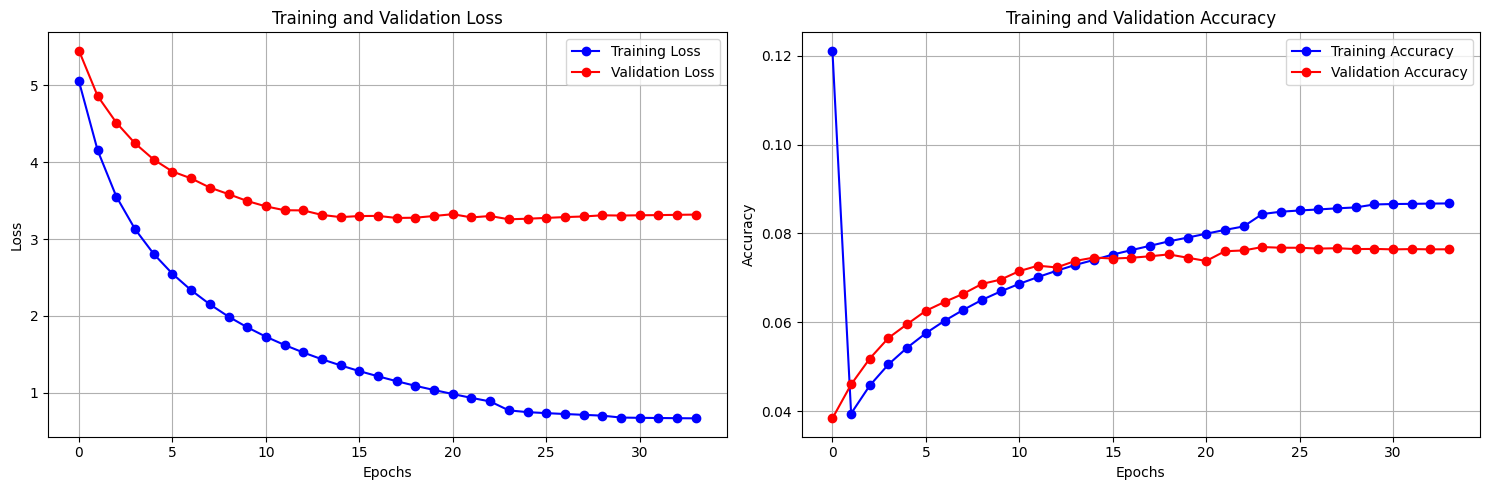

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# --- Plot 1: Loss vs Val Loss ---
ax1.plot(epochs, loss, 'bo-', label='Training Loss')      # 'bo-' means Blue dots with line
ax1.plot(epochs, val_loss, 'ro-', label='Validation Loss') # 'ro-' means Red dots with line
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# --- Plot 2: Accuracy vs Val Accuracy ---
ax2.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# INFERENCE SETUP

In [23]:
print(os.listdir('/kaggle/input/translateeng-spa/tensorflow2/default/1/'))

['model.h5']


In [29]:
try:
    model.load_weights("/kaggle/working/model.keras")
    print("✅ Success! Weights loaded from Input.")
except OSError:
    print("❌ Error: Double check the path.")

✅ Success! Weights loaded from Input.


In [30]:
# Encoder

encoder_model = Model(
    encoder_inputs,
    encoder_states
)

# Decoder

decoder_state_h = Input(shape = (256*2,))
decoder_state_c = Input(shape = (256*2,))
decoder_states = [decoder_state_h, decoder_state_c]

decoder_embeding_inference = decoder_emb_layer(decoder_inputs)

decoder_output_inference, state_h_inference, state_c_inference = decoder_lstm(
    decoder_embeding_inference, initial_state = decoder_states
)

decoder_state2 = [state_h_inference, state_c_inference]
decoder_output_inference = decoder_dense(decoder_output_inference)

decoder_model = Model(
    [decoder_inputs] + decoder_states,
    [decoder_output_inference] + decoder_state2
)

# Inference

In [31]:
def process_user_input(input_text):
    """
    Preprocesses a single user input string for inference.
    Does NOT fit a tokenizer. Uses the existing one to transform text.
    """
    # 1. Clean (Must match training cleaning exactly)
    #    - Lowercase is the most critical step here
    clean_text = input_text.lower()

    # 2. Text to Sequence
    #    - We use the GLOBAL 'tokenizer_input' that was already fitted on spa.txt
    #    - We wrap clean_text in a list [] because the function expects a list of strings
    seq = tokenizer_input.texts_to_sequences([clean_text])

    # 3. Pad Sequence
    #    - We use the GLOBAL 'max_len' determined during the training setup
    padded_seq = pad_sequences(seq, maxlen=max_len_encoder, padding='post')

    return padded_seq

In [32]:
def decode_sequence(input_text):
    # Step 1: Use the helper function to get the prepared data
    # (No tokenizing logic here, just calling the function)
    input_seq = process_user_input(input_text)

    # Step 2: Get the "Thought Vector" (Encode)
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Step 3: Start the Decoder Loop
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer_output.word_index['<start>']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        # Sample the token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer_output.index_word.get(sampled_token_index, '')

        if (sampled_word == '<end>' or len(decoded_sentence) > 100):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        # Update for next loop
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()

In [33]:
print("Chatbot Ready. Testing...")
print()
# ==========================================
# TEST DATA (English Input)
# ==========================================
test_data = [
    # 1. Imperatives (One word commands)
    "Go.",
    "Run.",
    "Wait.",
    "Stop.",

    # 2. Simple Greetings & Questions
    "Hi.",
    "Hello.",
    "Who are you?",
    "How are you?",
    "Where is he?",
    "Can I help you?",

    # 3. Simple Sentences (Subject + Verb + Object)
    "I am happy.",
    "She is my friend.",
    "He acts like a child.",
    "I like to read.",
    "The car is blue.",
    "We need more money.",

    # 4. Slightly Complex (Time/Conditionals)
    "I will go tomorrow.",
    "If you want, I can help.",
    "He speaks English very well.",
    "I have to go to sleep."
]

# ==========================================
# RUN BATCH PREDICTION
# ==========================================
print(f"{'ENGLISH INPUT':<30} | {'MODEL TRANSLATION'}")
print("-" * 60)

for text in test_data:
    # 1. Get prediction using your pipeline
    # (Clean -> Transform to Sequence -> Pad -> Predict)
    prediction = decode_sequence(text)

    # 2. Print result
    print(f"{text:<30} | {prediction}")

Chatbot Ready. Testing...

ENGLISH INPUT                  | MODEL TRANSLATION
------------------------------------------------------------
Go.                            | ¡órale
Run.                           | ¡órale
Wait.                          | espera
Stop.                          | deja de menos
Hi.                            | hola
Hello.                         | hola
Who are you?                   | ¿quién sos
How are you?                   | ¿cómo estás
Where is he?                   | ¿dónde está él
Can I help you?                | ¿puedo ayudarte
I am happy.                    | estoy feliz
She is my friend.              | ella es mi amigo
He acts like a child.          | él se parece como a un niño
I like to read.                | me gusta leer
The car is blue.               | el auto es azul
We need more money.            | necesitamos más dinero
I will go tomorrow.            | iré mañana
If you want, I can help.       | si quieres que yo puedes ayudar
He speaks Engli

In [34]:
# ==========================================
# UNSEEN DATA STRESS TEST
# ==========================================
unseen_data = [
    # --- Level 1: Novel Combinations ---
    "The blue dog is eating an apple.",
    "My sister bought a fast car yesterday.",
    "Why is the doctor dancing?",
    "I do not want to drink hot water.",

    # --- Level 2: Grammar & Structure ---
    "She saw me but I did not see her.",
    "If you study, you will win.",
    "Please give me the book and the pen.",

    # --- Level 3: Abstract/Hard ---
    "Time flies like an arrow.",
    "I am reading a book about elephants."
]

print(f"{'ENGLISH INPUT':<40} | {'MODEL TRANSLATION'}")
print("-" * 70)

for text in unseen_data:
    try:
        # Run your pipeline
        translation = decode_sequence(text)
        print(f"{text:<40} | {translation}")
    except Exception as e:
        print(f"{text:<40} | ❌ Error: {e}")

ENGLISH INPUT                            | MODEL TRANSLATION
----------------------------------------------------------------------
The blue dog is eating an apple.         | el perro que está roja con una botella de una manzana
My sister bought a fast car yesterday.   | mi hermana compró un auto y ayer
Why is the doctor dancing?               | ¿por qué el doctor es éxito
I do not want to drink hot water.        | no quiero tomar agua caliente
She saw me but I did not see her.        | ella me preguntó pero no había visto
If you study, you will win.              | si te comes lo podéis ganar
Please give me the book and the pen.     | por favor dame un bolígrafo y bolígrafo
Time flies like an arrow.                | el tiempo le tiró una piedra
I am reading a book about elephants.     | estoy leyendo un libro sobre libros
